In [1]:
# The gp_sfh.py file conta"ins a simple GP framework that we'll be using
from gp_sfh import *
import gp_sfh_kernels

#--------------------------------------------------------------------------------------
# import FSPS and set up a fiducial set of parameters (dust, metallicity, IMF, etc.)
#--------------------------------------------------------------------------------------

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

from copy import deepcopy
import hickle

import fsps
sp = fsps.StellarPopulation(imf_type=2, zcontinuous=1)
sp.params['imf_type'] = 1 # Chabrier
sp.params['logzsol'] = 0.0 # Solar metallicity
sp.params['dust_type'] = 2 # Calzetti
sp.params['dust2'] = 0.2
sp.params['sfh'] = 3
sp.params['add_neb_emission'] = True
sp.params['add_neb_continuum'] = True

import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style('white')
import pandas as pd
import corner

In [2]:
kernel_params_MW_1dex = [1.0, 2500/1e3, 150/1e3, 0.03, 25/1e3]
kernel_params_dwarf_1dex = [1.0, 30/1e3, 150/1e3, 0.03, 10/1e3]
kernel_params_noon_1dex = [1.0, 200/1e3, 100/1e3, 0.03, 50/1e3]
kernel_params_highz_1dex = [1.0, 15/1e3, 16/1e3, 0.03, 6/1e3]

TCF20_scattervals = [0.17, 0.53, 0.24, 0.27]
kernel_params_MW_TCF20 = [np.sqrt(TCF20_scattervals[0]**2/(1 + (0.03)**2)), 2500/1e3, 150/1e3, 0.03*np.sqrt(TCF20_scattervals[0]**2/(1 + (0.03)**2)), 25/1e3]
kernel_params_dwarf_TCF20 = [np.sqrt(TCF20_scattervals[1]**2/(1 + (0.03)**2)), 30/1e3, 150/1e3, 0.03*np.sqrt(TCF20_scattervals[1]**2/(1 + (0.03)**2)), 10/1e3]
kernel_params_noon_TCF20 = [np.sqrt(TCF20_scattervals[2]**2/(1 + (0.03)**2)), 200/1e3, 100/1e3, 0.03*np.sqrt(TCF20_scattervals[2]**2/(1 + (0.03)**2)), 50/1e3]
kernel_params_highz_TCF20 = [np.sqrt(TCF20_scattervals[3]**2/(1 + (0.03)**2)), 15/1e3, 16/1e3, 0.03*np.sqrt(TCF20_scattervals[3]**2/(1 + (0.03)**2)), 6/1e3]


MW \sigma_eff = sqrt(C(\tau=0)): 1.000 dex
dwarf \sigma_eff = sqrt(C(\tau=0)): 1.000 dex
noon \sigma_eff = sqrt(C(\tau=0)): 1.000 dex
highz \sigma_eff = sqrt(C(\tau=0)): 1.000 dex


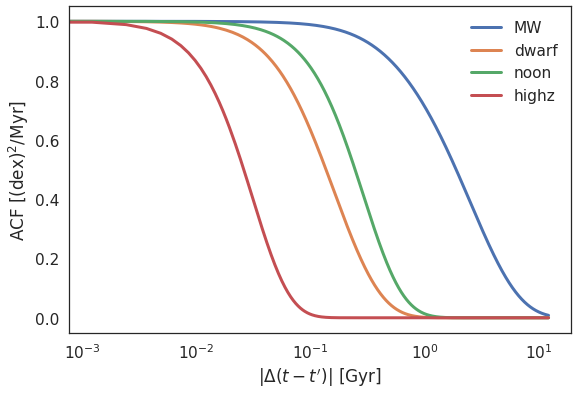

In [3]:
nsamp = 1000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_1dex, kernel_params_dwarf_1dex, kernel_params_noon_1dex, kernel_params_highz_1dex]

plt.figure(figsize=(9,6))

for i, case in enumerate(cases):
    
    deltat = np.linspace(0,cosmo.age(zval).value,tarr_res)
    plt.plot(deltat, gp_sfh_kernels.extended_regulator_model_kernel_paramlist(deltat, case_params[i]),lw=3,label=case)
    
    print(case+r' \sigma_eff = sqrt(C(\tau=0)): %.3f dex' %(np.sqrt(gp_sfh_kernels.extended_regulator_model_kernel_paramlist(deltat, case_params[i])[0])))
    
plt.legend(edgecolor='w')
plt.xscale('log');
#plt.xlim(1e-2,)
# plt.yscale('log')
# plt.ylim(1e-3,1e1)
plt.xlabel('$|\Delta (t-t\')|$ [Gyr]')
plt.ylabel('ACF [(dex)$^2$/Myr]')
plt.show()

# Stellar Mass distributions

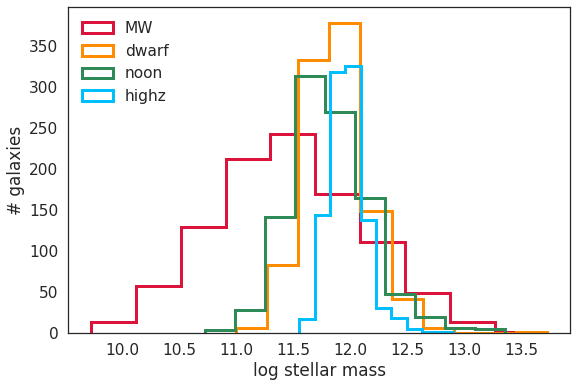

In [4]:
nsamp = 1000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_1dex, kernel_params_dwarf_1dex, kernel_params_noon_1dex, kernel_params_highz_1dex]
case_colors = ['crimson','darkorange','seagreen','deepskyblue']

plt.figure(figsize=(9,6))

for i, case in enumerate(cases):
    
    fname = 'precomputed_kernels/v2_ExReg_1dex_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.h5' %(tarr_res, zval, nsamp, random_seed)
    case1 = hickle.load(fname)
    plt.hist(np.log10(case1.mstar),histtype='step',lw=3,label=case,color=case_colors[i])
plt.legend(edgecolor='w')
#plt.xscale('log');plt.yscale('log')
#plt.ylim(1e-3,1e1)
plt.xlabel('log stellar mass')
plt.ylabel('# galaxies')
plt.savefig('figures/massdist_1dex.png')
plt.show()
    

10.885774425169936
11.17404990944158
10.926557599902186
10.949363588467993


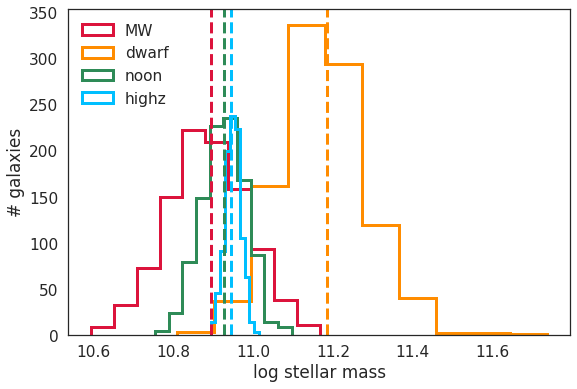

In [5]:
nsamp = 1000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_TCF20, kernel_params_dwarf_TCF20, kernel_params_noon_TCF20, kernel_params_highz_TCF20]
case_colors = ['crimson','darkorange','seagreen','deepskyblue']

plt.figure(figsize=(9,6))

for i, case in enumerate(cases):
    
    fname = 'precomputed_kernels/v2_ExReg_TCF20_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.h5' %(tarr_res, zval, nsamp, random_seed)
    case1 = hickle.load(fname)
    plt.hist(np.log10(case1.mstar),histtype='step',lw=3,label=case,color=case_colors[i])
    
    print(np.mean(np.log10(case1.mstar)))
    plt.axvline(10.86 + np.pi/np.e*TCF20_scattervals[i]**2,lw=3,color=case_colors[i],linestyle='--')

plt.legend(edgecolor='w')
#plt.xscale('log');plt.yscale('log')
#plt.ylim(1e-3,1e1)
plt.xlabel('log stellar mass')
plt.ylabel('# galaxies')
plt.savefig('figures/massdist_TCF20.png')
plt.show()
    

# Figure 3, ACFs and SFHs

In [6]:
def makeplot(fig, axs, axins, case1, kernelcolor, labelval, **kernelargs):

    axs[0].plot(case1.tarr, case1.kernel(case1.tarr, **kernelargs),lw=5,color=kernelcolor,label=labelval,zorder=100)
    axs[0].set_xlabel('$|\Delta (t-t\')|$ [Gyr]')
    axs[0].set_ylabel('ACF [(dex)$^2$/Myr]')
    axs[0].set_xscale('log')
    axs[0].set_xlim(np.amin(case1.tarr),np.amax(case1.tarr))
    
    tmep = case1.samples[0]
    
    #tmep = tmep/np.std(tmep)*0.6
#     axs[1].plot(case1.tarr, case1.samples[0],color=kernelcolor)
    axs[1].plot(case1.tarr, tmep,color=kernelcolor)
    axs[1].set_xlim(0,np.amax(case1.tarr));
    axs[1].set_ylim(-4,3)
    axs[1].set_xlabel('time [Gyr]')
    axs[1].set_ylabel('log SFR(t) [M$_\odot$yr$^{-1}$]')
    
    #axins.plot(case1.tarr, case1.samples[0],color=kernelcolor)
    axins.plot(case1.tarr, tmep,color=kernelcolor)
    # sub region of the original image
    x1, x2, y1, y2 = 2.5,3.0, -1.08,1.08
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticklabels('')
    #axins.set_yticklabels('')
    axs[1].indicate_inset_zoom(axins, edgecolor="black")

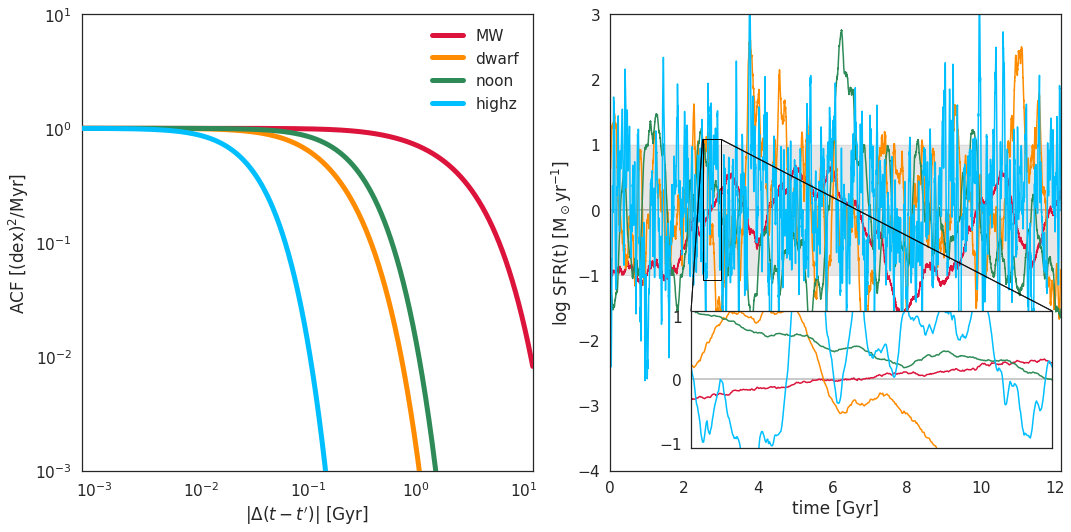

In [7]:
nsamp = 1000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_1dex, kernel_params_dwarf_1dex, kernel_params_noon_1dex, kernel_params_highz_1dex]
case_colors = ['crimson','darkorange','seagreen','deepskyblue']

fig, axs = plt.subplots(1,2,figsize=(10*1.5,5*1.5))
axins = axs[1].inset_axes([0.18, 0.05, 0.8, 0.3])

axs[1].plot(case1.tarr, np.zeros_like(case1.tarr),'k',alpha=0.3)
axins.plot(case1.tarr, np.zeros_like(case1.tarr),'k',alpha=0.3)

axs[1].fill_between(case1.tarr, np.ones_like(case1.tarr),np.ones_like(case1.tarr)*(-1.),color='k',alpha=0.1)

for i, case in enumerate(cases):
    
    fname = 'precomputed_kernels/v2_ExReg_1dex_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.h5' %(tarr_res, zval, nsamp, random_seed)
    case1 = hickle.load(fname)
    
    makeplot(fig, axs, axins, case1, kernelcolor=case_colors[i], labelval=case, 
                                     kernel_params = case_params[i])

    
axs[0].legend(edgecolor='w',loc=1,framealpha=0.1)
axs[0].set_yscale('log');axs[0].set_ylim(1e-3,1e1)
plt.tight_layout()
plt.savefig('figures/fig3_panel1_1dex.png',bbox_inches='tight')
plt.show()

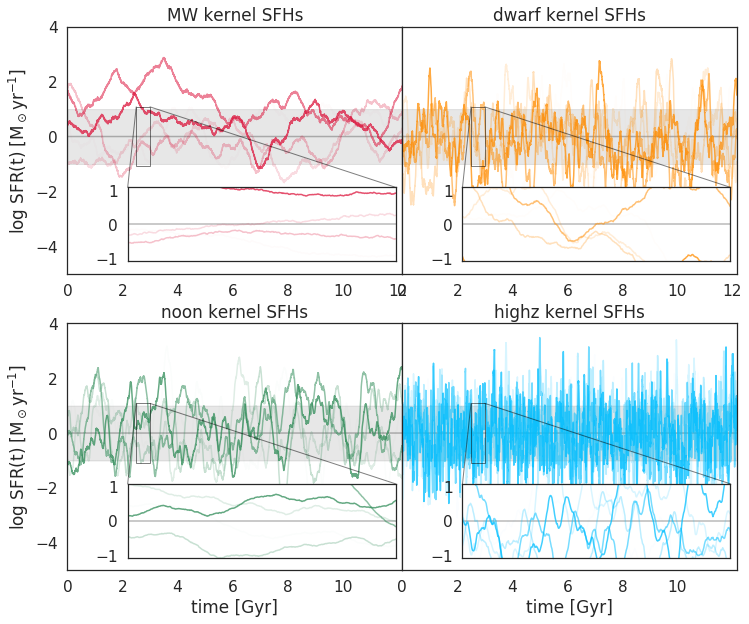

In [8]:
nsamp = 1000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_1dex, kernel_params_dwarf_1dex, kernel_params_noon_1dex, kernel_params_highz_1dex]
case_colors = ['crimson','darkorange','seagreen','deepskyblue']


fig, axs = plt.subplots(2,2,figsize=(12,10))
plt.subplots_adjust(wspace=0, hspace=0.2)
axins = []
for i, case in enumerate(cases):
    
    axins.append(axs[int(i/2),int(i%2)].inset_axes([0.18, 0.05, 0.8, 0.3]))
    axs[int(i/2),int(i%2)].plot(case1.tarr, np.zeros_like(case1.tarr),'k',alpha=0.3)
    axins[i].plot(case1.tarr, np.zeros_like(case1.tarr),'k',alpha=0.3)
    axs[int(i/2),int(i%2)].fill_between(case1.tarr, np.ones_like(case1.tarr),np.ones_like(case1.tarr)*(-1.),color='k',alpha=0.1)

    fname = 'precomputed_kernels/v2_ExReg_1dex_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.h5' %(tarr_res, zval, nsamp, random_seed)
    case1 = hickle.load(fname)
    
    np.random.seed(12)
    for j in range(5):
        tempalpha = np.random.uniform()
        tmep = case1.samples[j]
        #tmep = tmep/np.std(np.array(case1.samples))*0.6
        axs[int(i/2),int(i%2)].plot(case1.tarr, tmep,color=case_colors[i],alpha=tempalpha)
        axins[i].plot(case1.tarr, tmep,color=case_colors[i],alpha=tempalpha)
        
    axs[int(i/2),int(i%2)].set_xlim(0,np.amax(case1.tarr));
    axs[int(i/2),int(i%2)].set_ylim(-5,4)
    if (i == 0) or (i==2):
        axs[int(i/2),int(i%2)].set_ylabel('log SFR(t) [M$_\odot$yr$^{-1}$]')
    else:
        axs[int(i/2),int(i%2)].set_yticks([])
    if (i>1):
        axs[int(i/2),int(i%2)].set_xlabel('time [Gyr]')
        axs[int(i/2),int(i%2)].set_xticks(np.arange(0,12,2))
    axs[int(i/2),int(i%2)].set_title(case+' kernel SFHs')
        
    # sub region of the original image
    x1, x2, y1, y2 = 2.5,3.0, -1.08,1.08
    axins[i].set_xlim(x1, x2)
    axins[i].set_ylim(y1, y2)
    axins[i].set_xticklabels('')
    #axins.set_yticklabels('')
    axs[int(i/2),int(i%2)].indicate_inset_zoom(axins[i], edgecolor="black")
    
#plt.tight_layout()
plt.savefig('figures/fig3_panel2_1dex.png',bbox_inches='tight')
plt.show()

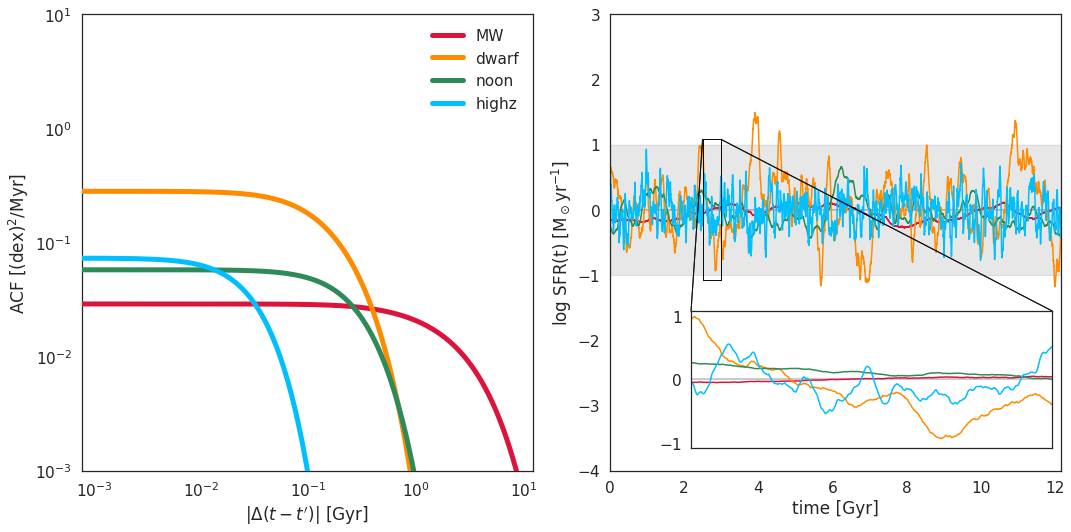

In [9]:
nsamp = 1000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_TCF20, kernel_params_dwarf_TCF20, kernel_params_noon_TCF20, kernel_params_highz_TCF20]
case_colors = ['crimson','darkorange','seagreen','deepskyblue']

fig, axs = plt.subplots(1,2,figsize=(10*1.5,5*1.5))
axins = axs[1].inset_axes([0.18, 0.05, 0.8, 0.3])

axs[1].plot(case1.tarr, np.zeros_like(case1.tarr),'k',alpha=0.3)
axins.plot(case1.tarr, np.zeros_like(case1.tarr),'k',alpha=0.3)

axs[1].fill_between(case1.tarr, np.ones_like(case1.tarr),np.ones_like(case1.tarr)*(-1.),color='k',alpha=0.1)

for i, case in enumerate(cases):
    
    fname = 'precomputed_kernels/v2_ExReg_TCF20_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.h5' %(tarr_res, zval, nsamp, random_seed)
    case1 = hickle.load(fname)
    
    makeplot(fig, axs, axins, case1, kernelcolor=case_colors[i], labelval=case, 
                                     kernel_params = case_params[i])

    
axs[0].legend(edgecolor='w',loc=1,framealpha=0.1)
axs[0].set_yscale('log');axs[0].set_ylim(1e-3,1e1)
plt.tight_layout()
plt.savefig('figures/fig3_panel1_TCF20.png',bbox_inches='tight')
plt.show()

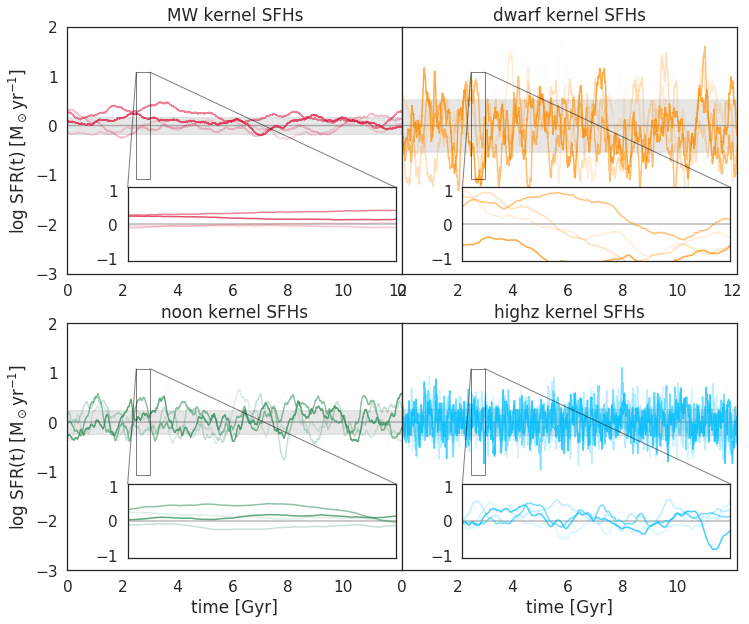

In [10]:
nsamp = 1000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_TCF20, kernel_params_dwarf_TCF20, kernel_params_noon_TCF20, kernel_params_highz_TCF20]
case_colors = ['crimson','darkorange','seagreen','deepskyblue']


fig, axs = plt.subplots(2,2,figsize=(12,10))
plt.subplots_adjust(wspace=0, hspace=0.2)
axins = []
for i, case in enumerate(cases):
    
    axins.append(axs[int(i/2),int(i%2)].inset_axes([0.18, 0.05, 0.8, 0.3]))
    axs[int(i/2),int(i%2)].plot(case1.tarr, np.zeros_like(case1.tarr),'k',alpha=0.3)
    axins[i].plot(case1.tarr, np.zeros_like(case1.tarr),'k',alpha=0.3)
    axs[int(i/2),int(i%2)].fill_between(case1.tarr, np.ones_like(case1.tarr)*TCF20_scattervals[i],np.ones_like(case1.tarr)*(-1.)*TCF20_scattervals[i],color='k',alpha=0.1)

    fname = 'precomputed_kernels/v2_ExReg_TCF20_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.h5' %(tarr_res, zval, nsamp, random_seed)
    case1 = hickle.load(fname)
    
    np.random.seed(12)
    for j in range(5):
        tempalpha = np.random.uniform()
        tmep = case1.samples[j]
        #tmep = tmep/np.std(np.array(case1.samples))*0.6
        axs[int(i/2),int(i%2)].plot(case1.tarr, tmep,color=case_colors[i],alpha=tempalpha)
        axins[i].plot(case1.tarr, tmep,color=case_colors[i],alpha=tempalpha)
        
    axs[int(i/2),int(i%2)].set_xlim(0,np.amax(case1.tarr));
    axs[int(i/2),int(i%2)].set_ylim(-3,2)
    if (i == 0) or (i==2):
        axs[int(i/2),int(i%2)].set_ylabel('log SFR(t) [M$_\odot$yr$^{-1}$]')
    else:
        axs[int(i/2),int(i%2)].set_yticks([])
    if (i>1):
        axs[int(i/2),int(i%2)].set_xlabel('time [Gyr]')
        axs[int(i/2),int(i%2)].set_xticks(np.arange(0,12,2))
    axs[int(i/2),int(i%2)].set_title(case+' kernel SFHs')
        
    # sub region of the original image
    x1, x2, y1, y2 = 2.5,3.0, -1.08,1.08
    axins[i].set_xlim(x1, x2)
    axins[i].set_ylim(y1, y2)
    axins[i].set_xticklabels('')
    #axins.set_yticklabels('')
    axs[int(i/2),int(i%2)].indicate_inset_zoom(axins[i], edgecolor="black")
    
#plt.tight_layout()
plt.savefig('figures/fig3_panel2_TCF20.png',bbox_inches='tight')
plt.show()

# Figure 4: Spectral Features

100%|██████████| 1000/1000 [00:00<00:00, 13554.41it/s]


<Figure size 648x432 with 0 Axes>

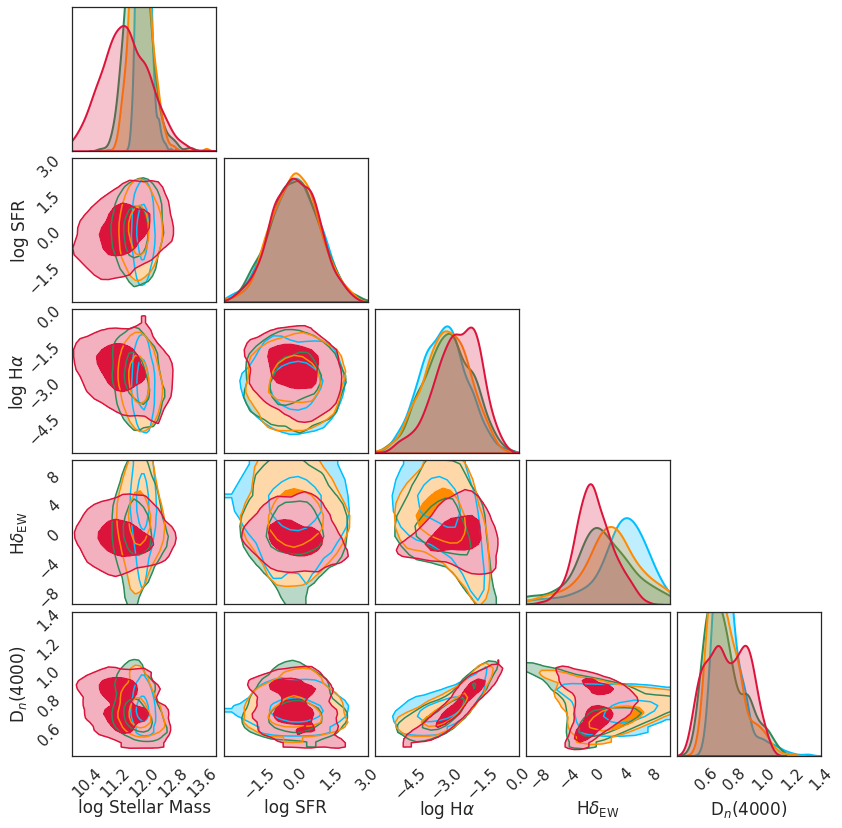

In [11]:
nsamp = 1000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_1dex, kernel_params_dwarf_1dex, kernel_params_noon_1dex, kernel_params_highz_1dex]
case_colors = ['crimson','darkorange','seagreen','deepskyblue']

plt.figure(figsize=(9,6))

smoothval = 1.0
nbins = 1000
binvals = [np.linspace(10,14,nbins), np.linspace(-3,3,nbins), np.linspace(-6,0,nbins), np.linspace(-10,10,nbins), np.linspace(0.4,1.4,nbins)]

for i, case in reversed(list(enumerate(cases))):
    
    fname = 'precomputed_kernels/v2_ExReg_1dex_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.h5' %(tarr_res, zval, nsamp, random_seed)
    case1 = hickle.load(fname)

    case1.calc_spectral_features(massnorm = True)
    
    temphd = np.array(case1.hdelta_ews.copy())
    #temphd[temphd < -11] = -11
    
    tempha = np.array(np.log10(case1.ha_lums).copy())
    #tempha[tempha < -6] = -6
    
    case1_specfeatures = np.vstack((np.log10(case1.mstar), 
                                    (np.array(case1.samples)[0:,0]),
                                    tempha, temphd, case1.dn4000_vals))

    if i==3:
        fig = corner.corner(case1_specfeatures.T, 
                      labels=['log Stellar Mass', 'log SFR', r'log H$\alpha$', r'H$\delta_{\rm EW}$', 'D$_n$(4000)'],
                      levels=[1 - np.exp(-(1/1)**2/2),1 - np.exp(-(2/1)**2/2)], # quantiles=(0.16,0.84), 
                      plot_datapoints=False, fill_contours=True, smooth=smoothval,
                      color = case_colors[i], hist_kwargs={'lw':0, 'density':True})
        axes = np.array(fig.axes).reshape((5,5))
        all_specfeatures = case1_specfeatures
        
        for kdei in range(5):
            axkde = axes[kdei, kdei]
            sns.kdeplot(case1_specfeatures[kdei,0:],shade=True,lw=2,color=case_colors[i],ax=axkde)
            axkde.set_ylabel('')
        
    elif i<4:
        fig = corner.corner(case1_specfeatures.T, 
              levels=[1 - np.exp(-(1/1)**2/2),1 - np.exp(-(2/1)**2/2)], #quantiles=(0.16,0.84), 
              plot_datapoints=False, fill_contours=True, smooth=smoothval,
              color = case_colors[i], fig = fig, hist_kwargs={'lw':0, 'density':True})
        
        for kdei in range(5):
            axkde = axes[kdei, kdei]
            sns.kdeplot(case1_specfeatures[kdei,0:],shade=True,lw=2,color=case_colors[i],ax=axkde)
            axkde.set_ylabel('')
        all_specfeatures = np.hstack((all_specfeatures, case1_specfeatures))
        
# Extract the axes


lims = [(10,14),(-3,3),(-6,0),(-10,10),(0.4,1.4)]


for i in range(5):
    ax = axes[i, i]
    ax.set_xlim(lims[i])
    
    for j in range(i):
        ax = axes[i,j]
        ax.set_xlim(lims[j])
        ax.set_ylim(lims[i])
plt.savefig('figures/fig4_panel2_1dex.png',bbox_inches='tight')
plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 13263.08it/s]


<Figure size 648x432 with 0 Axes>

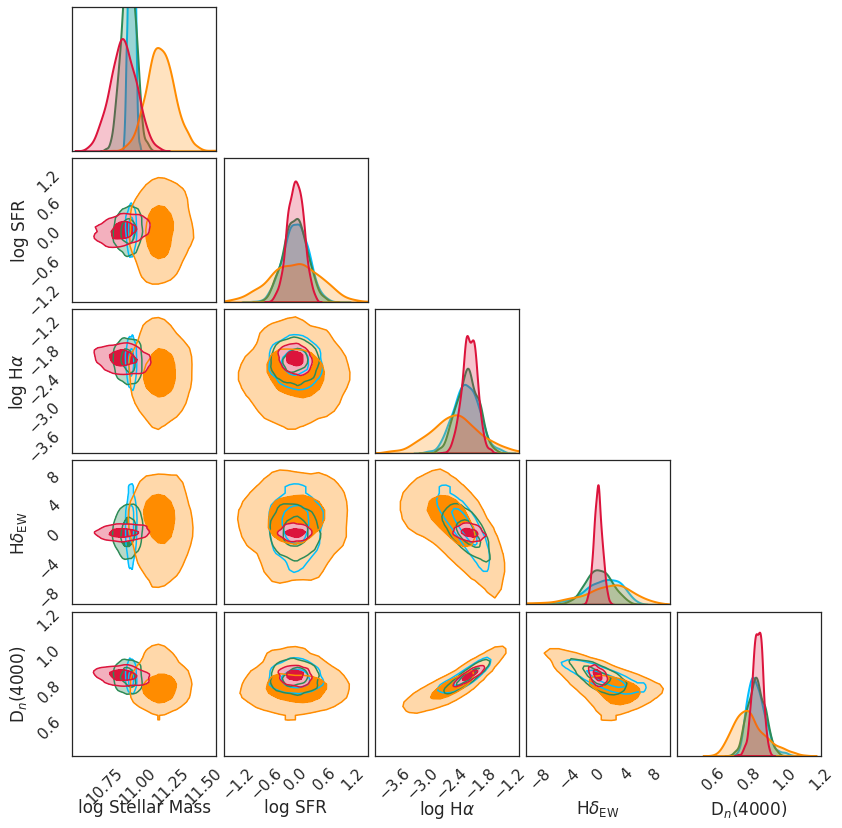

In [12]:
nsamp = 1000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_TCF20, kernel_params_dwarf_TCF20, kernel_params_noon_TCF20, kernel_params_highz_TCF20]
case_colors = ['crimson','darkorange','seagreen','deepskyblue']

plt.figure(figsize=(9,6))

smoothval = 1.0
nbins = 1000
binvals = [np.linspace(10,14,nbins), np.linspace(-3,3,nbins), np.linspace(-6,0,nbins), np.linspace(-10,10,nbins), np.linspace(0.4,1.4,nbins)]

for i, case in reversed(list(enumerate(cases))):
    
    fname = 'precomputed_kernels/v2_ExReg_TCF20_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.h5' %(tarr_res, zval, nsamp, random_seed)
    case1 = hickle.load(fname)

    case1.calc_spectral_features(massnorm = True)
    
    temphd = np.array(case1.hdelta_ews.copy())
    #temphd[temphd < -11] = -11
    
    tempha = np.array(np.log10(case1.ha_lums).copy())
    #tempha[tempha < -6] = -6
    
    case1_specfeatures = np.vstack((np.log10(case1.mstar), 
                                    (np.array(case1.samples)[0:,0]),
                                    tempha, temphd, case1.dn4000_vals))

    if i==3:
        fig = corner.corner(case1_specfeatures.T, 
                      labels=['log Stellar Mass', 'log SFR', r'log H$\alpha$', r'H$\delta_{\rm EW}$', 'D$_n$(4000)'],
                      levels=[1 - np.exp(-(1/1)**2/2),1 - np.exp(-(2/1)**2/2)], # quantiles=(0.16,0.84), 
                      plot_datapoints=False, fill_contours=True, smooth=smoothval,
                      color = case_colors[i], hist_kwargs={'lw':0, 'density':True})
        axes = np.array(fig.axes).reshape((5,5))
        all_specfeatures = case1_specfeatures
        
        for kdei in range(5):
            axkde = axes[kdei, kdei]
            sns.kdeplot(case1_specfeatures[kdei,0:],shade=True,lw=2,color=case_colors[i],ax=axkde)
            axkde.set_ylabel('')
        
    elif i<4:
        fig = corner.corner(case1_specfeatures.T, 
              levels=[1 - np.exp(-(1/1)**2/2),1 - np.exp(-(2/1)**2/2)], #quantiles=(0.16,0.84), 
              plot_datapoints=False, fill_contours=True, smooth=smoothval,
              color = case_colors[i], fig = fig, hist_kwargs={'lw':0, 'density':True})
        
        for kdei in range(5):
            axkde = axes[kdei, kdei]
            sns.kdeplot(case1_specfeatures[kdei,0:],shade=True,lw=2,color=case_colors[i],ax=axkde)
            axkde.set_ylabel('')
        all_specfeatures = np.hstack((all_specfeatures, case1_specfeatures))
        
# Extract the axes


#lims = [(10,14),(-3,3),(-6,0),(-10,10),(0.4,1.4)]
lims = [(10.5,11.6),(-1.5,1.5),(-4,-1),(-10,10),(0.4,1.2)]


for i in range(5):
    ax = axes[i, i]
    ax.set_xlim(lims[i])
    
    for j in range(i):
        ax = axes[i,j]
        ax.set_xlim(lims[j])
        ax.set_ylim(lims[i])
plt.savefig('figures/fig4_panel2_TCF20.png',bbox_inches='tight')
plt.show()